In [127]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist, squareform
import statistics as stats
from scipy.signal import find_peaks


#### Get audio vector and inital tempo estimation

In [128]:
path = '../audio/aphex_twin_ageispolis_30_sec.mp3'
loader = estd.AudioLoader(filename=path)
downmixer = estd.MonoMixer()
tempAudioInput, fs, numb_channels, md5, bit_rate, codec = loader()
audioInput = downmixer(tempAudioInput, numb_channels)
tempo_estimation_algo = estd.PercivalBpmEstimator(sampleRate=int(fs))
bpm = tempo_estimation_algo(audioInput)
print(bpm)

101.83189392089844


#### Compute spectrogram and 2-band energy

In [129]:
# Dynamic Programming Python implementation of Min Cost Path
R = 30
C = 30
def minCost(cost, m, n): 
  
    # Instead of following line, we can use int tc[m+1][n+1] or 
    # dynamically allocate memoery to save space. The following 
    # line is used to keep te program simple and make it working 
    # on all compilers.
    tc = [[0 for x in range(C)] for x in range(R)] 
  
    tc[0][0] = cost[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m+1): 
        tc[i][0] = tc[i-1][0] + cost[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n+1): 
        tc[0][j] = tc[0][j-1] + cost[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m+1): 
        for j in range(1, n+1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j] 
  
    return tc[m][n] 

In [130]:
## var init
frame_size = 1024
hop_size = 512
fft_size = 1024

## get necessary Essentia algorithms
window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann')
fft_algo = estd.FFT(size = fft_size)

spectrogram = []
db_spectrogram = []
cutoff_bin = 5000*1024/fs
print('Frame Size:', frame_size)
print('FFT Size:', fft_size)

for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
    ## spectrogram
    windowed_frame = window_algo(frame)
    mX = abs(fft_algo(windowed_frame))
    mX[mX<np.finfo(float).eps] = np.finfo(float).eps    ## if zeros add epsilon to handle log
    dbX = 20 * np.log10(mX[:cutoff_bin+1])
    spectrogram.append(np.array(mX[:cutoff_bin+1]))
    db_spectrogram.append(np.array(dbX))
    
spectrogram = np.array(spectrogram)
db_spectrogram = np.array(db_spectrogram)
print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)

Frame Size: 1024
FFT Size: 1024
Spectrogram done. Size is (axis1, axis2): (2612, 117)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Plot Spectrogram (for visual feedback only)

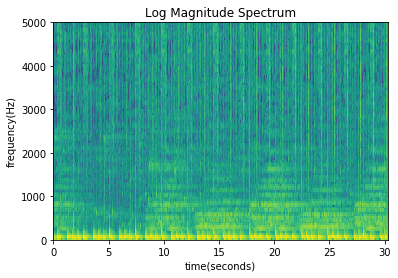

In [131]:
timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

In [132]:
# beat estimation
beatTracker = estd.BeatTrackerDegara()
beats = beatTracker(audioInput)
beats_frames = [int(bf) for bf in (beats * fs / hop_size)]
#print(beats)
print(len(beats))
#print(beats_frames)

51


In [133]:
# for i in range(len(beats)-1):
#     dur_beats.append(beats[i+1] - beats[i])
#     pc8_dur_beats.append(dur_beats[i] * 0.08)

# avDur = np.average(dur_beats)
# avDurInFrames = int(avDur * fs / hop_size)
# avDur8 = np.average(pc8_dur_beats)
# avDur8InFrames = int(avDur8 * fs / hop_size)
# print(avDurInFrames)
# print(avDur8InFrames)

# framePosBeat = []
beats_neighbour_spect = {}
i = 0

while i <= len(beats_frames)-1:
    if i != len(beats_frames)-1:
        beat_duration = beats_frames[i+1] - beats_frames[i]
    duration_8_percent = int(beat_duration*0.08)
    beats_neighbour_spect[beats_frames[i]] = spectrogram[beats_frames[i]-duration_8_percent:beats_frames[i]+duration_8_percent]
    i += 1

ASM_dict = {}
for beat_x in beats_neighbour_spect:
    ASM_dict[beat_x] = {}
    for beat_y in beats_neighbour_spect:
        temp_ASM = cdist(beats_neighbour_spect[beat_x], beats_neighbour_spect[beat_y], metric='euclidean')
        ASM_dict[beat_x][beat_y] = temp_ASM

In [134]:
print(len(beats_frames))

51


In [135]:
BSM = []
counti = 0 
for beat_frame_i, ASM_beat_dict in ASM_dict.items():
    BSM.append([])
    for beat_frame_j, ASM in ASM_beat_dict.items():
        BSM[counti].append(minCost(ASM, ASM.shape[0]-1, ASM.shape[1]-1))
    counti += 1

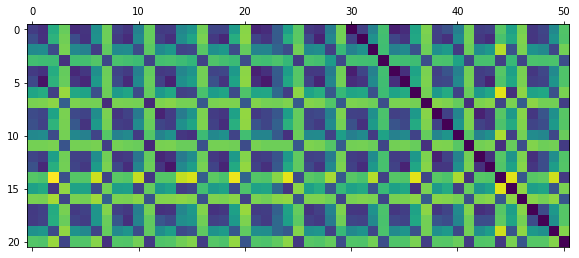

In [136]:
plt.matshow(BSM[30:90])

In [137]:
len(BSM)

51

In [138]:
d = []
d_inverted = []
for i, beat in enumerate(BSM):
    d.append(stats.mean(list(np.diagonal(BSM, i))))
    d_inverted.append(-d[i])
d_inverted += max([abs(item) for item in d])

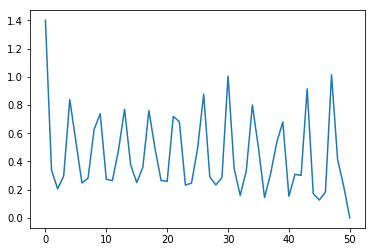

In [139]:
plt.plot(d_inverted)

In [140]:
d_peaks = find_peaks(d_inverted)[0]
for i in d_peaks:
    d_inverted[i] *= 2

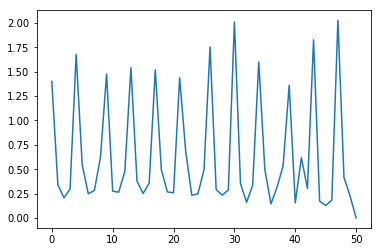

In [141]:
plt.plot(d_inverted)

In [142]:
d_inverted

array([ 1.40133355,  0.33968058,  0.20638688,  0.29609648,  1.67812665,
        0.54281542,  0.24756014,  0.28162193,  0.6273987 ,  1.47723256,
        0.27433349,  0.26457774,  0.4781343 ,  1.54112229,  0.37726691,
        0.25031314,  0.35819385,  1.52056257,  0.49371545,  0.2661895 ,
        0.25821481,  1.43902595,  0.682333  ,  0.23243174,  0.24708745,
        0.49296309,  1.7544015 ,  0.29182968,  0.23356084,  0.28676592,
        2.01090723,  0.35163061,  0.15973382,  0.33414627,  1.60078274,
        0.49590963,  0.14439347,  0.31451039,  0.53465997,  1.36103553,
        0.15400345,  0.61829119,  0.30158822,  1.82885246,  0.17209545,
        0.1267126 ,  0.18364191,  2.02913953,  0.41470815,  0.2246421 ,  0.        ])

In [143]:
bar_candidates = list(range(2,12))
lt = math.floor(len(beats)/11)
tc = []
for c in bar_candidates:
    t_sum = 0
    for p in range(1, lt+1):
        t_sum += (d_inverted[p*c]/(1-((p-1)/lt)))
    tc.append(t_sum)

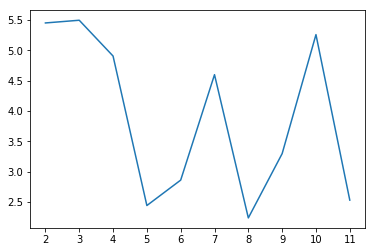

In [144]:
plt.xticks(list(range(10)), bar_candidates)
plt.plot(tc)